In [1]:
import os
import random
import zipfile
import urllib.request
import itertools
import numpy as np
from keras.preprocessing import image
import seaborn as sns
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD, RMSprop

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_file_name = '/content/drive/Othercomputers/My Computer/Computer vision/projects/dl and cnns/adidas/archive.zip'
dir = './images'
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(dir)
zip_ref.close()

In [4]:
print('number of training adidas images: ', len(os.listdir('./images/train/adidas/')))
print('number of training converse images: ', len(os.listdir('./images/train/converse/')))
print('number of training nike images: ', len(os.listdir('./images/train/nike/')))
print('number of testing adidas images: ', len(os.listdir('./images/test/adidas/')))
print('number of testing converse images: ', len(os.listdir('./images/test/converse/')))
print('number of testing nike images: ', len(os.listdir('./images/test/nike/')))

number of training adidas images:  237
number of training converse images:  237
number of training nike images:  237
number of testing adidas images:  38
number of testing converse images:  38
number of testing nike images:  38


In [5]:
TRAINING_DIR = './images/train/'
train_generator = ImageDataGenerator( 
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest').flow_from_directory(TRAINING_DIR,
                                             batch_size=32,
                                             class_mode='categorical',
                                             target_size=(240, 240))

VALIDATION_DIR = './images/test/'
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(VALIDATION_DIR,
                                        batch_size=32,
                                        class_mode='categorical',
                                        target_size=(240, 240))

Found 711 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(240, 240, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

In [7]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 240, 240, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 120, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 120, 120, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 60, 60, 64)        0

In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard
#Overwrite the model each time accuracy improves. Saves a lot of space. 
filepath="./best_model.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, accuracy, loss, val_accuracy, val_loss. So we can plot later.
log_csv = CSVLogger('/content/drive/MyDrive/Colab Notebooks/saved_logs/my_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint]
tb = TensorBoard(log_dir='.')

In [9]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 3.3266 - accuracy: 0.3516
Epoch 1: val_accuracy improved from -inf to 0.36842, saving model to ./best_model.hdf5
23/23 [==============================] - 17s 536ms/step - loss: 3.3266 - accuracy: 0.3516 - val_loss: 1.0976 - val_accuracy: 0.3684
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.1002 - accuracy: 0.3263
Epoch 2: val_accuracy did not improve from 0.36842
23/23 [==============================] - 10s 422ms/step - loss: 1.1002 - accuracy: 0.3263 - val_loss: 1.0971 - val_accuracy: 0.3333
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.0903 - accuracy: 0.3586
Epoch 3: val_accuracy improved from 0.36842 to 0.40351, saving model to ./best_model.hdf5
23/23 [==============================] - 12s 533ms/step - loss: 1.0903 - accuracy: 0.3586 - val_loss: 1.0851 - val_accuracy: 0.4035
Epoch 4/20
23/23 [==============================] - ETA: 0s - loss: 1.0873 - accuracy: 0.3572


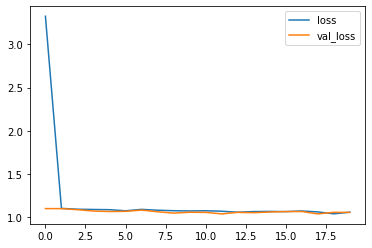

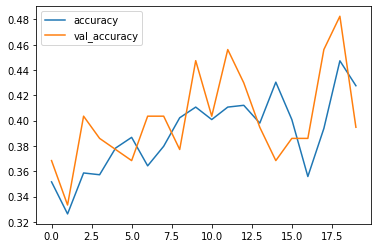

In [10]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [11]:
loss, accuracy = model.evaluate(validation_generator, batch_size=32)
print(loss, accuracy)

4/4 [==============================] - 0s 61ms/step - loss: 1.0530 - accuracy: 0.3947
1.0529991388320923 0.3947368562221527
